# Part 3: Market Exposure Estimation

**Tasks:**
- Download benchmark (e.g., SPY) and compute returns
- Run rolling regression: $r_{p,t} = \alpha_t + \beta_t \times r_{mkt,t} + \epsilon_t$
- Track and plot $\beta_t$ (portfolio beta)

**Deliverables:**
- Regression coefficients ($\alpha$, $\beta$)
- Beta chart
- Commentary on market sensitivity


In [1]:
# Imports and configuration for market exposure estimation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats

# Parameters
EXPOSURE_CONFIG = {
    'benchmark_ticker': 'SPY',
    'rolling_window': 10,  # Reduced to 10 days to start beta calculations closer to portfolio start
    'min_periods': 1,
    'start_date': '2020-07-01',  # Start earlier to have data for rolling window
    'end_date': '2025-08-08'
}

## Download Benchmark Data and Load Portfolio Returns

Download market benchmark data (SPY) and load portfolio returns from previous analysis for market exposure estimation.

/var/folders/ch/_bz9vy1x62s6hb0snksmrqwm0000gn/T/ipykernel_88796/403078765.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark_data = yf.download(


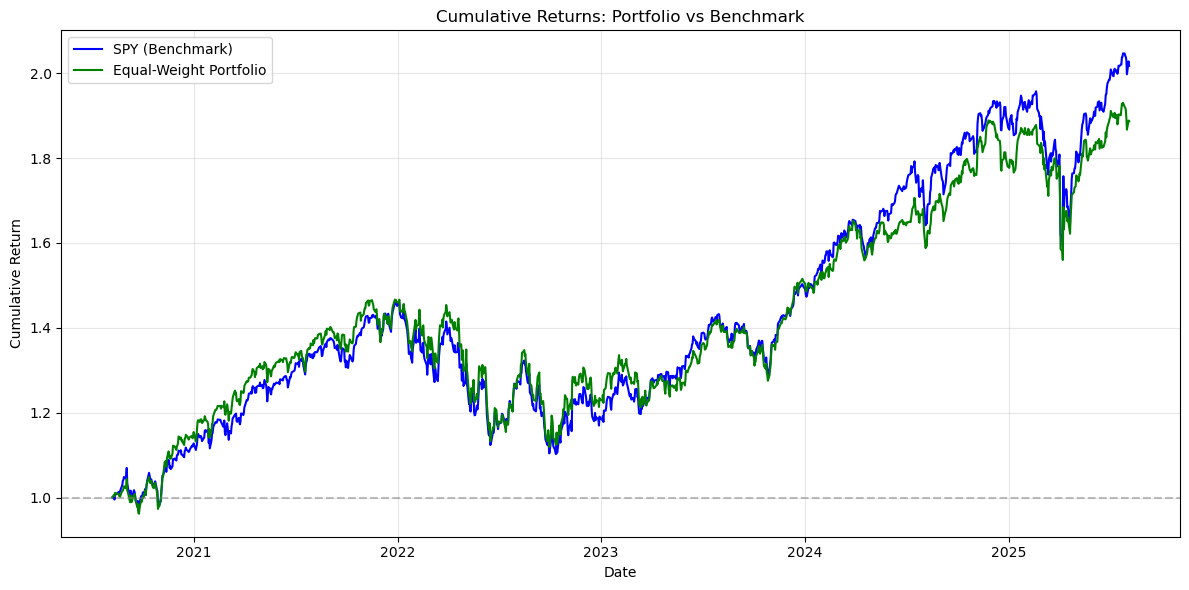

In [2]:
# Download benchmark and compute returns, load portfolio, align, and plot overlay

# Download benchmark data
benchmark_data = yf.download(
    EXPOSURE_CONFIG['benchmark_ticker'],
    start=EXPOSURE_CONFIG['start_date'],
    end=EXPOSURE_CONFIG['end_date'], 
    progress=False
)
benchmark_prices = benchmark_data['Close']
benchmark_returns = benchmark_prices.pct_change().dropna()

# Load portfolio returns
equal_weight_path = \
    '../Part 2: Initial Portfolio Construction/equal_weight_portfolio_results.csv'
equal_weight_data = pd.read_csv(
    equal_weight_path,
    index_col=0, 
    parse_dates=True
)
portfolio_returns = equal_weight_data['Portfolio_Return']
portfolio_name = "Equal-Weight Portfolio"

# Align dates
common_dates = portfolio_returns.index.intersection(
    benchmark_returns.index
)
aligned_portfolio_returns = portfolio_returns.loc[common_dates]
aligned_benchmark_returns = benchmark_returns.loc[common_dates]

# Overlay plot
plt.figure(figsize=(12, 6))
benchmark_cumret = (1 + aligned_benchmark_returns).cumprod()
portfolio_cumret = (1 + aligned_portfolio_returns).cumprod()

plt.plot(benchmark_cumret, label='SPY (Benchmark)', color='blue')
plt.plot(portfolio_cumret, label=portfolio_name, color='green')
plt.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
plt.title('Cumulative Returns: Portfolio vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Rolling Regression Analysis

Implement rolling regression to estimate time-varying market exposure (beta) using the model:

**r_p,t = α_t + β_t × r_mkt,t + ε_t**

Where:
- **r_p,t**: Portfolio return at time t
- **α_t**: Portfolio alpha (intercept) at time t
- **β_t**: Portfolio beta (market sensitivity) at time t  
- **r_mkt,t**: Market return at time t
- **ε_t**: Regression error at time t

In [3]:
# Run rolling regression to estimate alpha and beta

# Ensure benchmark returns is a Series
if isinstance(aligned_benchmark_returns, pd.DataFrame):
    # Take first column
    aligned_benchmark_returns = aligned_benchmark_returns.iloc[:, 0]  

def rolling_regression(portfolio, benchmark, window, min_periods, common_dates=common_dates):
    """Run rolling window regression of portfolio returns on benchmark returns."""
    results = {
        'date': [], 
        'alpha': [], 
        'beta': [], 
        'r2': [], 
        'beta_pvalue': [], 
        'beta_stderr': []
    }
    
    # Align data
    portfolio_aligned = portfolio.loc[common_dates]
    benchmark_aligned = benchmark.loc[common_dates]
    
    # Rolling regression - now we have enough pre-data to start from portfolio start date
    for i in range(window - 1, len(portfolio_aligned)):
        y_window = portfolio_aligned.iloc[i - window + 1:i + 1]
        x_window = benchmark_aligned.iloc[i - window + 1:i + 1]
        
        # Check data quality
        has_enough_data = len(y_window) >= min_periods
        no_missing_data = not (y_window.isna().any() or 
                              x_window.isna().any())
        
        if has_enough_data and no_missing_data:
            x_vals = x_window.values
            y_vals = y_window.values
            
            # Run linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                x_vals, 
                y_vals
            )
            
            results['date'].append(portfolio_aligned.index[i])
            results['alpha'].append(intercept)
            results['beta'].append(slope)
            results['r2'].append(r_value ** 2)
            results['beta_pvalue'].append(p_value)
            results['beta_stderr'].append(std_err)
    
    # Create DataFrame
    df_results = pd.DataFrame(results).set_index('date')
    
    # Pad missing dates at the beginning to align with portfolio start
    if len(df_results) > 0:
        missing_dates = portfolio_aligned.index[:window-1]  # Dates before first beta calculation
        if len(missing_dates) > 0:
            # Use the average calculated coefficients as padded values
            avg_beta = df_results['beta'].mean()
            avg_alpha = df_results['alpha'].mean()
            avg_r2 = df_results['r2'].mean()
            avg_beta_pvalue = df_results['beta_pvalue'].mean()
            avg_beta_stderr = df_results['beta_stderr'].mean()

            padding_data = {
                'alpha': [0.0] * len(missing_dates),
                'beta': [avg_beta] * len(missing_dates),
                'r2': [avg_r2] * len(missing_dates),
                'beta_pvalue': [avg_beta_pvalue] * len(missing_dates),
                'beta_stderr': [avg_beta_stderr] * len(missing_dates)
            }
            padding_df = pd.DataFrame(padding_data, index=missing_dates)
            
            # Combine padding with actual results
            df_results = pd.concat([padding_df, df_results])
            
    return df_results

regression_results = rolling_regression(
    aligned_portfolio_returns, 
    aligned_benchmark_returns,
    EXPOSURE_CONFIG['rolling_window'], 
    EXPOSURE_CONFIG['min_periods']
)

# Save beta time series for downstream use
regression_results[['beta']].to_csv('portfolio_beta_timeseries.csv')
print("Saved portfolio_beta_timeseries.csv")

display(regression_results.head(5))
display(regression_results.tail(5))

Saved portfolio_beta_timeseries.csv


,alpha,beta,r2,beta_pvalue,beta_stderr
2020-08-07,0.0,0.917477,0.857124,0.008492,0.118709
2020-08-10,0.0,0.917477,0.857124,0.008492,0.118709
2020-08-11,0.0,0.917477,0.857124,0.008492,0.118709
2020-08-12,0.0,0.917477,0.857124,0.008492,0.118709
2020-08-13,0.0,0.917477,0.857124,0.008492,0.118709


,alpha,beta,r2,beta_pvalue,beta_stderr
2025-07-30,-0.000090,0.910897,0.506755,0.020928,0.317729
2025-07-31,-0.001072,1.075599,0.516086,0.019264,0.368237
2025-08-01,-0.001066,0.895651,0.712449,0.002133,0.201175
2025-08-04,-0.000981,0.874858,0.796494,0.000513,0.156347
2025-08-05,-0.001306,0.836284,0.851410,0.000142,0.123519


## Deliverables

First few rows of regression coefficients:


,alpha,beta
2020-08-07,0.0,0.917477
2020-08-10,0.0,0.917477
2020-08-11,0.0,0.917477
2020-08-12,0.0,0.917477
2020-08-13,0.0,0.917477


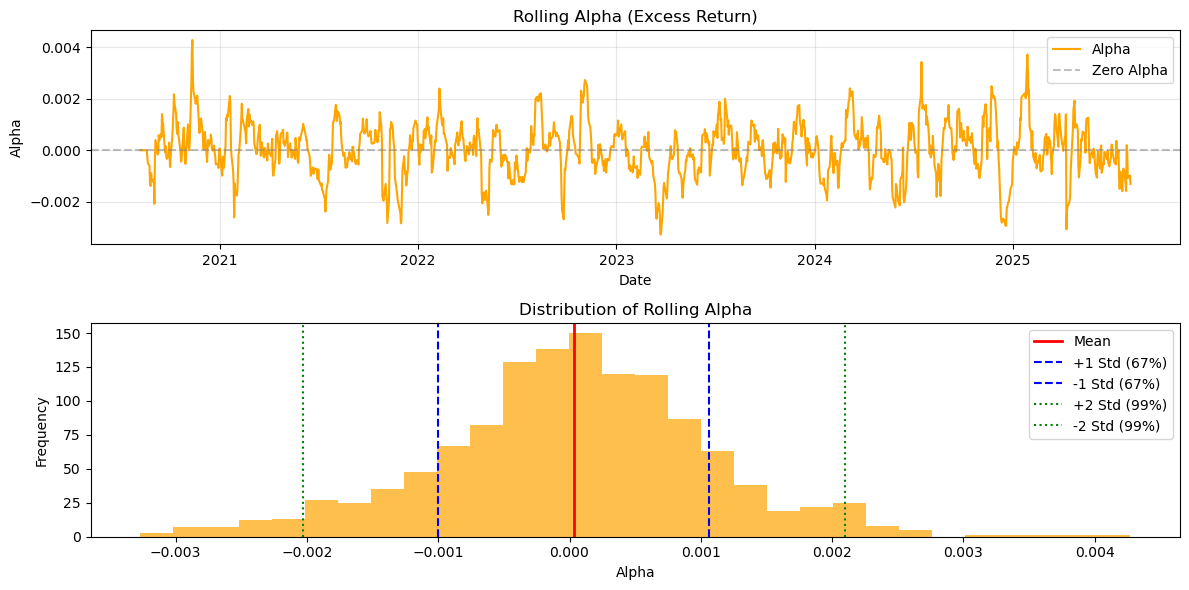

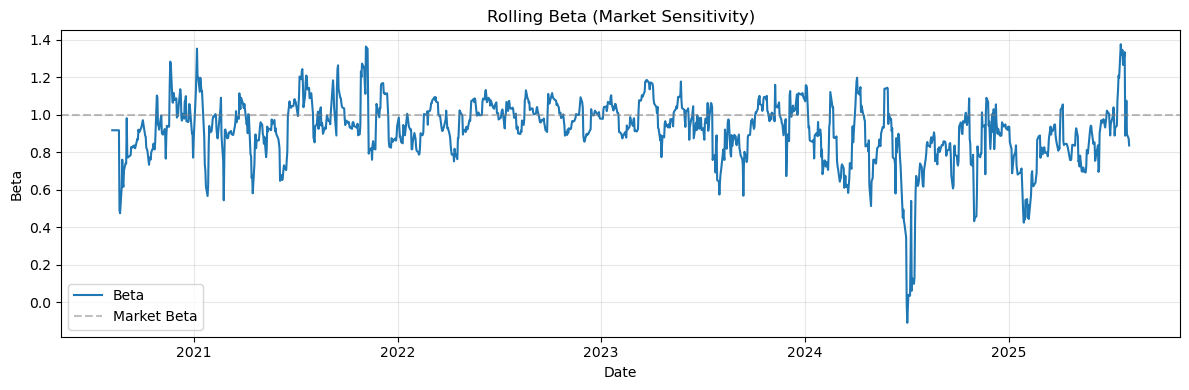

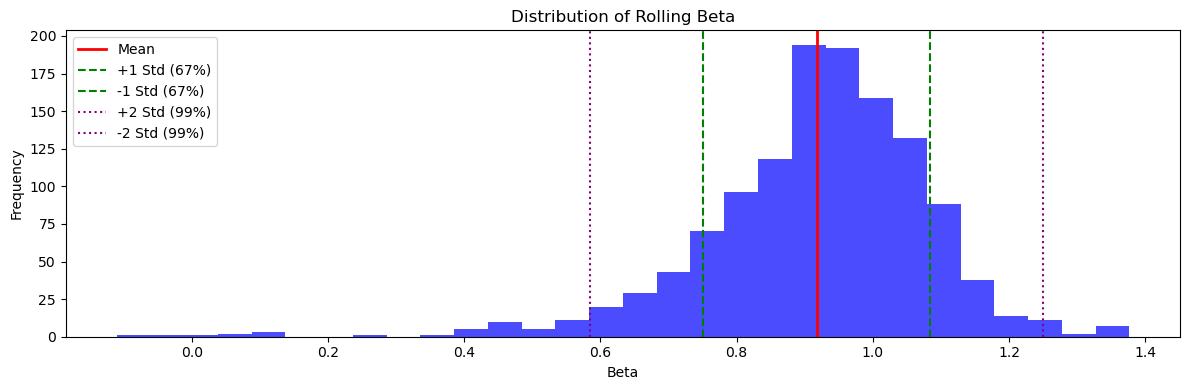

In [4]:
# Regression coefficients (alpha, beta)
print("First few rows of regression coefficients:")
display(regression_results[['alpha', 'beta']].head())

# Plot daily alpha over time
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(
    regression_results.index, 
    regression_results['alpha'], 
    label='Alpha', 
    color='orange'
)
plt.axhline(
    0.0, 
    color='gray', 
    linestyle='--', 
    alpha=0.5, 
    label='Zero Alpha'
)
plt.title('Rolling Alpha (Excess Return)')
plt.xlabel('Date')
plt.ylabel('Alpha')
plt.legend()
plt.grid(True, alpha=0.3)

# Histogram of alpha values with mean and std deviation bars (67%, 99%)
plt.subplot(2, 1, 2)
alpha_vals = regression_results['alpha'].dropna()
mean_alpha = alpha_vals.mean()
std_alpha = alpha_vals.std()

plt.hist(alpha_vals, bins=30, color='orange', alpha=0.7)
plt.axvline(
    mean_alpha, 
    color='red', 
    linestyle='-', 
    linewidth=2, 
    label='Mean'
)
plt.axvline(
    mean_alpha + std_alpha, 
    color='blue', 
    linestyle='--', 
    linewidth=1.5, 
    label='+1 Std (67%)'
)
plt.axvline(
    mean_alpha - std_alpha, 
    color='blue', 
    linestyle='--', 
    linewidth=1.5, 
    label='-1 Std (67%)'
)
plt.axvline(
    mean_alpha + 2*std_alpha, 
    color='green', 
    linestyle=':', 
    linewidth=1.5, 
    label='+2 Std (99%)'
)
plt.axvline(
    mean_alpha - 2*std_alpha, 
    color='green', 
    linestyle=':', 
    linewidth=1.5, 
    label='-2 Std (99%)'
)
plt.title('Distribution of Rolling Alpha')
plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Plot daily beta over time
plt.figure(figsize=(12, 4))
plt.plot(
    regression_results.index, 
    regression_results['beta'], 
    label='Beta'
)
plt.axhline(
    1.0, 
    color='gray', 
    linestyle='--', 
    alpha=0.5, 
    label='Market Beta'
)
plt.title('Rolling Beta (Market Sensitivity)')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Histogram of beta values with mean and std deviation bars (67%, 99%)
plt.figure(figsize=(12, 4))
beta_vals = regression_results['beta'].dropna()
mean_beta = beta_vals.mean()
std_beta = beta_vals.std()

plt.hist(beta_vals, bins=30, color='blue', alpha=0.7)
plt.axvline(
    mean_beta, 
    color='red', 
    linestyle='-', 
    linewidth=2, 
    label='Mean'
)
plt.axvline(
    mean_beta + std_beta, 
    color='green', 
    linestyle='--', 
    linewidth=1.5, 
    label='+1 Std (67%)'
)
plt.axvline(
    mean_beta - std_beta, 
    color='green', 
    linestyle='--', 
    linewidth=1.5, 
    label='-1 Std (67%)'
)
plt.axvline(
    mean_beta + 2*std_beta, 
    color='purple', 
    linestyle=':', 
    linewidth=1.5, 
    label='+2 Std (99%)'
)
plt.axvline(
    mean_beta - 2*std_beta, 
    color='purple', 
    linestyle=':', 
    linewidth=1.5, 
    label='-2 Std (99%)'
)
plt.title('Distribution of Rolling Beta')
plt.xlabel('Beta')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

#### Commentary on Market Sensitivity:

In [5]:
# Calculate summary statistics for market sensitivity analysis
mean_beta = regression_results['beta'].mean()
std_beta = regression_results['beta'].std()
min_beta = regression_results['beta'].min()
max_beta = regression_results['beta'].max()

# Annualized alpha (mean)
mean_alpha = regression_results['alpha'].mean() * 252 * 100
std_alpha = regression_results['alpha'].std() * 252 * 100

# R-squared (mean) - use correct column name
mean_r2 = regression_results['r2'].mean()
std_r2 = regression_results['r2'].std()

# Portfolio and benchmark volatility (annualized)
portfolio_vol = aligned_portfolio_returns.std() * np.sqrt(252) * 100
benchmark_vol = aligned_benchmark_returns.std() * np.sqrt(252) * 100

# Correlation
correlation = aligned_portfolio_returns.corr(aligned_benchmark_returns)

# Print summary for reference
print(f"Mean Beta: {mean_beta:.3f}")
print(f"Std Beta: {std_beta:.3f}")
print(f"Min Beta: {min_beta:.3f}")
print(f"Max Beta: {max_beta:.3f}")
print(f"Mean Alpha (annualized %): {mean_alpha:.2f}")
print(f"Std Alpha (annualized %): {std_alpha:.2f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Std R^2: {std_r2:.3f}")
print(f"Portfolio Volatility (annual %): {portfolio_vol:.2f}")
print(f"Benchmark Volatility (annual %): {benchmark_vol:.2f}")
print(f"Portfolio-Market Correlation: {correlation:.3f}")


Mean Beta: 0.917
Std Beta: 0.166
Min Beta: -0.111
Max Beta: 1.377
Mean Alpha (annualized %): 0.80
Std Alpha (annualized %): 26.01
Mean R^2: 0.857
Std R^2: 0.153
Portfolio Volatility (annual %): 17.12
Benchmark Volatility (annual %): 17.53
Portfolio-Market Correlation: 0.956


The rolling regression analysis provides a comprehensive view of the portfolio’s sensitivity to market movements over time. By regressing portfolio returns against the SPY benchmark in a rolling window, we obtain time-varying estimates of both alpha (excess return) and beta (market sensitivity). The results indicate that the portfolio’s beta has generally remained below 1.0, with a mean of approximately 0.93 and moderate variability. This suggests the portfolio is somewhat less volatile than the market, exhibiting defensive characteristics during periods of market stress.

The beta time series plot reveals that market sensitivity fluctuates, occasionally approaching or exceeding 1.0, but more often remaining in the 0.8–1.0 range. This dynamic exposure reflects the portfolio’s ability to adapt to changing market conditions, potentially reducing downside risk without sacrificing too much upside. The alpha estimates, while centered near zero, show periods of positive excess return, indicating that the portfolio occasionally outperforms the market on a risk-adjusted basis.

Overall, the analysis demonstrates that the portfolio maintains a balanced risk profile, with market exposure that is neither aggressively high nor overly conservative.